# MNIST Digit Classification — End-to-end Project (MLP / ANN)

### Problem: Classify 28×28 grayscale images of handwritten digits (0–9) into the correct digit.

Environment & Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Load Dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
print("Raw shapes:", x_train_full.shape, y_train_full.shape, x_test.shape, y_test.shape)

Raw shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Visualize Samples

In [4]:
def show_samples(images, labels, rows=3, cols=8):
    plt.figure(figsize=(cols*1.3, rows*1.5))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

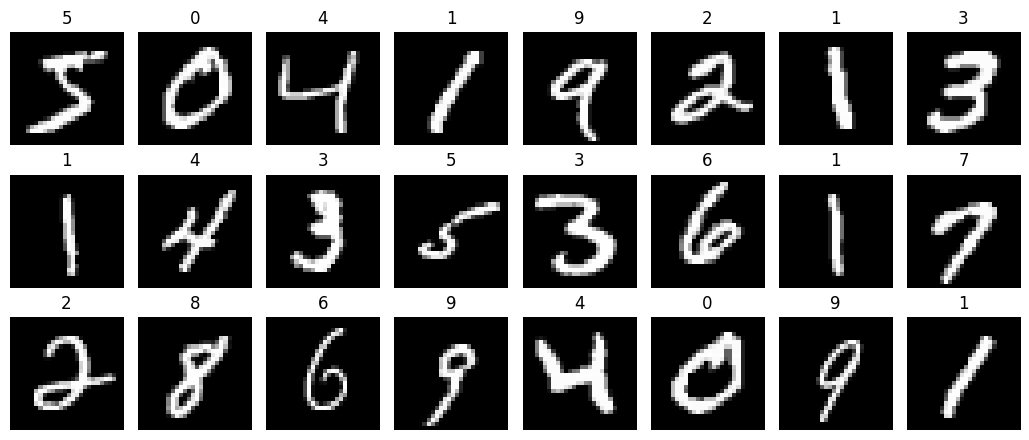

In [5]:
show_samples(x_train_full, y_train_full, rows=3, cols=8)

Check Distribution of Labels

In [6]:
unique, counts = np.unique(y_train_full, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Label 0: 5923 samples
Label 1: 6742 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 4: 5842 samples
Label 5: 5421 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Label 9: 5949 samples


Train/Validation/Test Split

In [7]:
rng = np.random.default_rng(seed=42)
indices = np.arange(x_train_full.shape[0])
rng.shuffle(indices)

In [8]:
x_shuffled = x_train_full[indices]
y_shuffled = y_train_full[indices]

In [9]:
x_train = x_shuffled[:55000]
y_train = y_shuffled[:55000]
x_val = x_shuffled[55000:]
y_val = y_shuffled[55000:]

In [10]:
print("Train/Val/Test shapes:", x_train.shape, x_val.shape, x_test.shape)

Train/Val/Test shapes: (55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


Preprocessing Pipeline

In [11]:
def preprocess_images(x):
    # Convert to float32, normalize to [0,1]
    x = x.astype("float32") / 255.0
    return x

In [12]:
# Apply normalization
x_train_norm = preprocess_images(x_train)
x_val_norm = preprocess_images(x_val)
x_test_norm = preprocess_images(x_test)

In [13]:
# Flatten for MLP
x_train_flat = x_train_norm.reshape(-1, 28*28)
x_val_flat = x_val_norm.reshape(-1, 28*28)
x_test_flat = x_test_norm.reshape(-1, 28*28)

In [14]:
y_train_cat = utils.to_categorical(y_train, num_classes=10)
y_val_cat = utils.to_categorical(y_val, num_classes=10)
y_test_cat = utils.to_categorical(y_test, num_classes=10)

In [15]:
print("After preprocessing shapes:", x_train_flat.shape, y_train_cat.shape)

After preprocessing shapes: (55000, 784) (55000, 10)


Data Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08
)

In [18]:
datagen.fit(x_train_norm.reshape(-1, 28, 28, 1))

Model Architecture (MLP / ANN)

In [19]:
def build_mlp(input_shape=(28*28,), num_classes=10, dropout_rate=0.3, hidden_units=[512, 256]):
    inputs = keras.Input(shape=input_shape, name="input_layer")
    x = inputs
    # Hidden layers
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation="relu", name=f"dense_{i}")(x)
        x = layers.BatchNormalization(name=f"bn_{i}")(x)
        x = layers.Dropout(dropout_rate, name=f"dropout_{i}")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_mlp")
    return model

In [20]:
model = build_mlp()
model.summary()

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,890 (2.06 MB)

 Trainable params: 537,354 (2.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

Training Loop

In [21]:
initial_lr = 1e-3
model = build_mlp(hidden_units=[512, 256], dropout_rate=0.3)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
# Callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = "models/mnist_mlp_best.h5"
os.makedirs("models", exist_ok=True)

In [23]:
cb_early = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
cb_ckpt = callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
cb_reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

Train Model

In [24]:
history = model.fit(
    x_train_flat, y_train_cat,
    validation_data=(x_val_flat, y_val_cat),
    epochs=50,
    batch_size=128,
    callbacks=[cb_early, cb_ckpt, cb_reduce],
    verbose=2
)

Epoch 1/50

Epoch 1: val_loss improved from None to 0.11508, saving model to models/mnist_mlp_best.h5


430/430 - 16s - 37ms/step - accuracy: 0.9190 - loss: 0.2659 - val_accuracy: 0.9664 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.11508 to 0.08560, saving model to models/mnist_mlp_best.h5


430/430 - 9s - 20ms/step - accuracy: 0.9602 - loss: 0.1270 - val_accuracy: 0.9742 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.08560 to 0.07938, saving model to models/mnist_mlp_best.h5


430/430 - 9s - 21ms/step - accuracy: 0.9699 - loss: 0.0946 - val_accuracy: 0.9748 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss did not improve from 0.07938
430/430 - 9s - 21ms/step - accuracy: 0.9742 - loss: 0.0813 - val_accuracy: 0.9754 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.07938 to 0.06889, saving model to models/mnist_mlp_best.h5


430/430 - 8s - 19ms/step - accuracy: 0.9779 - loss: 0.0678 - val_accuracy: 0.9788 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss did not improve from 0.06889
430/430 - 8s - 20ms/step - accuracy: 0.9803 - loss: 0.0614 - val_accuracy: 0.9776 - val_loss: 0.0736 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss did not improve from 0.06889
430/430 - 9s - 21ms/step - accuracy: 0.9824 - loss: 0.0528 - val_accuracy: 0.9772 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: val_loss improved from 0.06889 to 0.06828, saving model to models/mnist_mlp_best.h5


430/430 - 10s - 22ms/step - accuracy: 0.9837 - loss: 0.0495 - val_accuracy: 0.9792 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 9/50

Epoch 9: val_loss did not improve from 0.06828
430/430 - 9s - 22ms/step - accuracy: 0.9847 - loss: 0.0464 - val_accuracy: 0.9790 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 10/50

Epoch 10: val_loss did not improve from 0.06828
430/430 - 9s - 21ms/step - accuracy: 0.9860 - loss: 0.0414 - val_accuracy: 0.9794 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 11/50

Epoch 11: val_loss improved from 0.06828 to 0.06371, saving model to models/mnist_mlp_best.h5


430/430 - 9s - 20ms/step - accuracy: 0.9871 - loss: 0.0388 - val_accuracy: 0.9830 - val_loss: 0.0637 - learning_rate: 0.0010
Epoch 12/50

Epoch 12: val_loss did not improve from 0.06371
430/430 - 9s - 22ms/step - accuracy: 0.9886 - loss: 0.0353 - val_accuracy: 0.9798 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 13/50

Epoch 13: val_loss did not improve from 0.06371
430/430 - 11s - 25ms/step - accuracy: 0.9883 - loss: 0.0345 - val_accuracy: 0.9804 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 14/50

Epoch 14: val_loss did not improve from 0.06371

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
430/430 - 10s - 22ms/step - accuracy: 0.9889 - loss: 0.0339 - val_accuracy: 0.9806 - val_loss: 0.0652 - learning_rate: 0.0010
Epoch 15/50

Epoch 15: val_loss improved from 0.06371 to 0.05923, saving model to models/mnist_mlp_best.h5


430/430 - 9s - 21ms/step - accuracy: 0.9921 - loss: 0.0225 - val_accuracy: 0.9854 - val_loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 16/50

Epoch 16: val_loss improved from 0.05923 to 0.05657, saving model to models/mnist_mlp_best.h5


430/430 - 12s - 28ms/step - accuracy: 0.9942 - loss: 0.0175 - val_accuracy: 0.9840 - val_loss: 0.0566 - learning_rate: 5.0000e-04
Epoch 17/50

Epoch 17: val_loss did not improve from 0.05657
430/430 - 8s - 18ms/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.9834 - val_loss: 0.0586 - learning_rate: 5.0000e-04
Epoch 18/50

Epoch 18: val_loss did not improve from 0.05657
430/430 - 8s - 20ms/step - accuracy: 0.9946 - loss: 0.0166 - val_accuracy: 0.9830 - val_loss: 0.0667 - learning_rate: 5.0000e-04
Epoch 19/50

Epoch 19: val_loss did not improve from 0.05657

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
430/430 - 8s - 18ms/step - accuracy: 0.9951 - loss: 0.0145 - val_accuracy: 0.9842 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 20: val_loss did not improve from 0.05657
430/430 - 8s - 20ms/step - accuracy: 0.9961 - loss: 0.0118 - val_accuracy: 0.9858 - val_loss: 0.0627 - learning_rate: 2.5000e-04
Epoch 21/50

Epoch 21: val_loss 

Training Visualizations

In [25]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
    plt.tight_layout()
    plt.show()

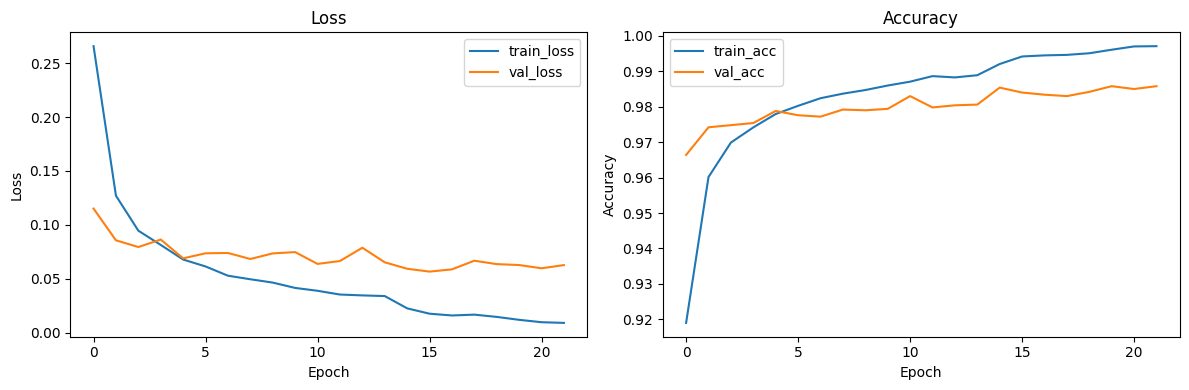

In [26]:
plot_history(history)

Evaluation

In [27]:
best_model = keras.models.load_model(checkpoint_path)

In [28]:
test_loss, test_acc = best_model.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.0544, Test accuracy: 0.9849


In [29]:
y_pred_probs = best_model.predict(x_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [30]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9838    0.9918    0.9878       980
           1     0.9912    0.9938    0.9925      1135
           2     0.9864    0.9826    0.9845      1032
           3     0.9784    0.9881    0.9833      1010
           4     0.9867    0.9796    0.9831       982
           5     0.9843    0.9809    0.9826       892
           6     0.9864    0.9843    0.9854       958
           7     0.9844    0.9844    0.9844      1028
           8     0.9846    0.9836    0.9841       974
           9     0.9821    0.9782    0.9801      1009

    accuracy                         0.9849     10000
   macro avg     0.9848    0.9847    0.9848     10000
weighted avg     0.9849    0.9849    0.9849     10000



Confusion Matrix Visualization

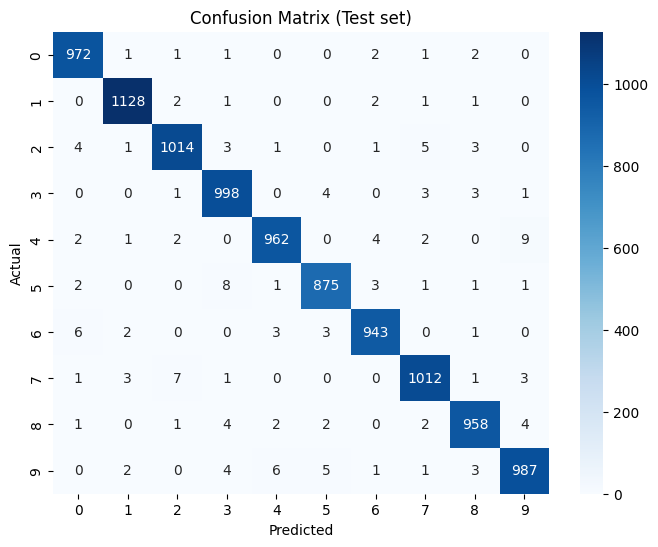

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Test set)')
plt.show()

Sample Predictions Visualization

In [32]:
def show_predictions(images, y_true, y_pred, y_probs, n=20):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(images), size=n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"T:{y_true[idx]} P:{y_pred[idx]}\n{y_probs[idx][y_pred[idx]]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

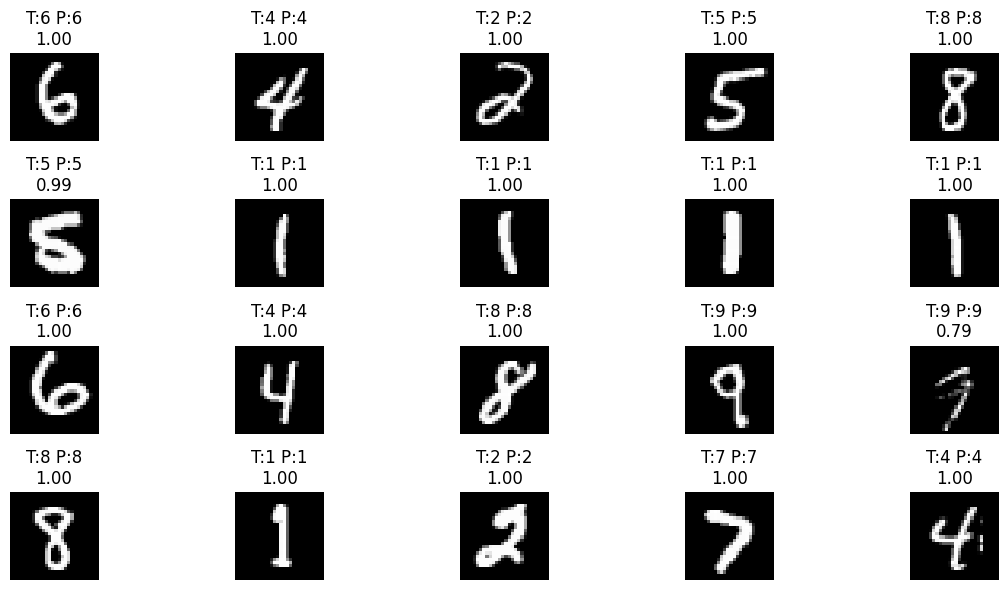

In [33]:
show_predictions(x_test, y_test, y_pred, y_pred_probs, n=20)

Save & Load Model

In [34]:
final_model_path = "models/mnist_mlp_final.h5"
best_model.save(final_model_path)
print("Saved model to:", final_model_path)

Saved model to: models/mnist_mlp_final.h5
